In [18]:
import os, math
import numpy as np
import tensorflow.compat.v1 as tf
from glob       import glob
from PIL        import Image
from matplotlib import pyplot

tf.disable_v2_behavior()
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
class MNIST_Generator():
    
    def __init__(self, data_files, z_dim, beta1, epoch_count, batch_size, lr):
    
        self.data_files = data_files
        self.data_shape = (len(data_files), 28, 28, 1)
        self.z_dim = z_dim
        self.beta1 = beta1
        self.epoch_count = epoch_count
        self.batch_size = batch_size
        self.lr = lr
        
        self.real_input, self.z_input, self.lr_tensor, \
        self.d_opt, self.g_opt, self.d_loss, self.g_loss = self.build_model()
        
    def build_model(self):
        
        real_input = tf.placeholder(tf.float32, (None, self.data_shape[1], self.data_shape[2], 1))
        z_input    = tf.placeholder(tf.float32, (None, self.z_dim))
        lr_tensor  = tf.placeholder(tf.float32)
        
        # Generator
        g_model = self.build_generator_model(z_input)
        
        # Discriminator
        d_model_real, d_logits_real = self.build_discriminator_model(real_input)
        d_model_fake, d_logits_fake = self.build_discriminator_model(g_model, reuse=True)
        
        # Model Loss
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
        d_loss      = d_loss_real + d_loss_fake
        
        g_loss      = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
        
        # Model Optimizer
        d_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')]
        g_train_vars = [var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')]
        
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_opt = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(d_loss, var_list=d_train_vars)
            g_opt = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(g_loss, var_list=g_train_vars)
        
        return real_input, z_input, lr_tensor, d_opt, g_opt, d_loss, g_loss
        
    def build_generator_model(self, z_input, reuse=False, alpha=0.1):
        
        with tf.variable_scope('generator', reuse=reuse):
        
            #input layer, fully connected
            h1 = tf.layers.dense(z_input, 7 * 7 * 256)

            #deconv layer 2, output 14x14x128
            h2   = tf.reshape(h1, (-1, 7, 7, 256))
            h2   = tf.layers.conv2d_transpose(h2, 128, 5, strides=2,padding='same')
            bn2  = tf.layers.batch_normalization(h2)
            out2 = tf.maximum(bn2, bn2*alpha)

            #deconv layer 3, output 28x28x3
            h3   = tf.layers.conv2d_transpose(out2, 1, 5, strides=2,padding='same')
            bn3  = tf.layers.batch_normalization(h3)
            out3 = tf.maximum(bn3, bn3*alpha)

            #output
            output = tf.tanh(out3)
        
        return output
    
    def build_discriminator_model(self, images, reuse=False, alpha=0.1):
        
        with tf.variable_scope('discriminator', reuse=reuse):

            #First layer, output 14x14x64
            h1   = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            out1 = tf.maximum(h1, h1*alpha)

            #second layer, output 7x7x128
            h2   = tf.layers.conv2d(out1, 128, 5, strides=2, padding='same')
            bn2  = tf.layers.batch_normalization(h2)
            out2 = tf.maximum(bn2, bn2*alpha)

            #third layer, output 4x4x256
            h3   = tf.layers.conv2d(out2, 256, 5, strides=2, padding='same')
            bn3  = tf.layers.batch_normalization(h3)
            out3 = tf.maximum(bn3, bn3*alpha)

            #final dense layer
            dense_input = tf.reshape(out3, (-1, 4 * 4 * 256))
            logits      = tf.layers.dense(dense_input, 1)
            out         = tf.sigmoid(logits) 

        return out, logits
    
    def get_batches(self):

        current_index = 0
        while current_index + self.batch_size <= self.data_shape[0]:
            
            image_files   = self.data_files[current_index:current_index + self.batch_size]
            width, height = self.data_shape[1], self.data_shape[2]
            data_batch    = np.array([self.get_image(sample_file, width, height) for sample_file in image_files]).astype(np.float32)
            
            # Make sure the images are in 4 dimensions
            if len(data_batch.shape) < 4:
                data_batch = data_batch.reshape(data_batch.shape + (1,))

            current_index += self.batch_size
            yield data_batch / 255 - 0.5
        
    def get_image(self, image_path, width, height):
        
        image = Image.open(image_path)
        
        if image.size != (width, height):
            image = image.resize([width, height], Image.BILINEAR)

        return np.array(image.convert('L'))
    
    def images_square_grid(self, images):
        # Get maximum size for square grid of images
        save_size = math.floor(np.sqrt(images.shape[0]))
        
        # Scale to 0-255
        images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
        
        # Put images in a square arrangement
        images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3])
        )
        
        images_in_square = np.squeeze(images_in_square, 4)
        
        # Combine images to grid image
        new_im = Image.new('L', (images.shape[1] * save_size, images.shape[2] * save_size))
        
        for col_i, col_images in enumerate(images_in_square):
            for image_i, image in enumerate(col_images):
                im = Image.fromarray(image, 'L')
                new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

        return new_im

    def train(self):
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_i in range(self.epoch_count):
                print(f'Starting epoch {epoch_i+1} of {self.epoch_count}')
                
                for batch_i, batch_images in enumerate(self.get_batches()):
                    batch_images = batch_images * 2
                    batch_z      = np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim))
                    
                    sess.run(self.d_opt, feed_dict={
                        self.real_input : batch_images, 
                        self.z_input    : batch_z, 
                        self.lr_tensor  : self.lr
                    })
                    sess.run(self.g_opt, feed_dict={
                        self.real_input : batch_images, 
                        self.z_input    : batch_z, 
                        self.lr_tensor  : self.lr
                    })
                
                    if batch_i % 10 == 0:

                        train_loss_d = self.d_loss.eval({self.z_input: batch_z, self.real_input: batch_images, self.lr_tensor:self.lr})
                        train_loss_g = self.g_loss.eval({self.z_input: batch_z, self.lr_tensor:self.lr})
                        
                        print(f'Batch {batch_i} of {60000//self.batch_size}',
                              f'Discriminator Loss: {train_loss_d:.4f}',
                              f'Generator Loss: {train_loss_g:.4f}')

                    if batch_i % 100 == 0:
                        self.show_sample_generated(sess, 1)
    
    def show_sample_generated(self, sess, n_images):

        input_z   = tf.random_uniform((1, self.z_dim),-1,1)
        z_dim     = input_z.get_shape().as_list()[-1]
        example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

        samples = sess.run(
            self.build_generator_model(input_z, reuse=True),
            feed_dict={input_z: example_z}
        )
        
        images_grid = self.images_square_grid(samples)
        pyplot.imshow(images_grid, cmap='gray')
        pyplot.show()


(60000, 28, 28, 1)
Starting epoch 1 of 2
Batch 0 of 1875 Discriminator Loss: 0.9052 Generator Loss: 0.6754


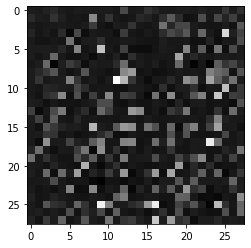

Batch 10 of 1875 Discriminator Loss: 0.0095 Generator Loss: 6.3147
Batch 20 of 1875 Discriminator Loss: 0.3225 Generator Loss: 1.9847
Batch 30 of 1875 Discriminator Loss: 0.5108 Generator Loss: 1.4567
Batch 40 of 1875 Discriminator Loss: 0.3767 Generator Loss: 2.8675
Batch 50 of 1875 Discriminator Loss: 0.3199 Generator Loss: 2.7632
Batch 60 of 1875 Discriminator Loss: 0.3935 Generator Loss: 1.6447
Batch 70 of 1875 Discriminator Loss: 1.9188 Generator Loss: 0.3182
Batch 80 of 1875 Discriminator Loss: 0.8250 Generator Loss: 2.9986
Batch 90 of 1875 Discriminator Loss: 0.7878 Generator Loss: 1.0654
Batch 100 of 1875 Discriminator Loss: 0.5419 Generator Loss: 1.8769


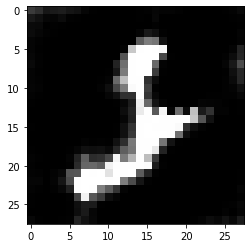

Batch 110 of 1875 Discriminator Loss: 0.8031 Generator Loss: 0.9945
Batch 120 of 1875 Discriminator Loss: 0.5266 Generator Loss: 2.2191
Batch 130 of 1875 Discriminator Loss: 0.5703 Generator Loss: 2.5400
Batch 140 of 1875 Discriminator Loss: 0.7375 Generator Loss: 1.0562
Batch 150 of 1875 Discriminator Loss: 0.6761 Generator Loss: 1.2008
Batch 160 of 1875 Discriminator Loss: 0.6418 Generator Loss: 2.3402
Batch 170 of 1875 Discriminator Loss: 0.5540 Generator Loss: 1.8883
Batch 180 of 1875 Discriminator Loss: 0.3076 Generator Loss: 2.2214
Batch 190 of 1875 Discriminator Loss: 0.6883 Generator Loss: 1.3135
Batch 200 of 1875 Discriminator Loss: 1.0762 Generator Loss: 1.1091


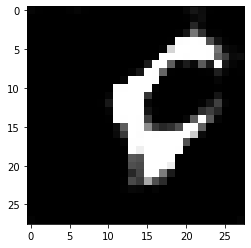

Batch 210 of 1875 Discriminator Loss: 0.6539 Generator Loss: 1.6238
Batch 220 of 1875 Discriminator Loss: 0.7039 Generator Loss: 1.2591
Batch 230 of 1875 Discriminator Loss: 0.4584 Generator Loss: 2.9384
Batch 240 of 1875 Discriminator Loss: 0.5170 Generator Loss: 1.7078
Batch 250 of 1875 Discriminator Loss: 0.4246 Generator Loss: 2.4382
Batch 260 of 1875 Discriminator Loss: 0.5497 Generator Loss: 1.2793
Batch 270 of 1875 Discriminator Loss: 0.6021 Generator Loss: 2.2304
Batch 280 of 1875 Discriminator Loss: 0.8869 Generator Loss: 0.8162
Batch 290 of 1875 Discriminator Loss: 0.6500 Generator Loss: 1.2417
Batch 300 of 1875 Discriminator Loss: 0.4691 Generator Loss: 1.6746


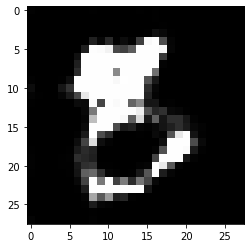

Batch 310 of 1875 Discriminator Loss: 0.6579 Generator Loss: 1.5894
Batch 320 of 1875 Discriminator Loss: 0.8427 Generator Loss: 1.0669
Batch 330 of 1875 Discriminator Loss: 0.8905 Generator Loss: 2.9095
Batch 340 of 1875 Discriminator Loss: 0.3987 Generator Loss: 1.9561
Batch 350 of 1875 Discriminator Loss: 0.5768 Generator Loss: 1.6986
Batch 360 of 1875 Discriminator Loss: 0.6414 Generator Loss: 1.5805
Batch 370 of 1875 Discriminator Loss: 0.4709 Generator Loss: 2.2280
Batch 380 of 1875 Discriminator Loss: 0.4133 Generator Loss: 2.0856
Batch 390 of 1875 Discriminator Loss: 0.6588 Generator Loss: 2.1354
Batch 400 of 1875 Discriminator Loss: 0.6749 Generator Loss: 1.3424


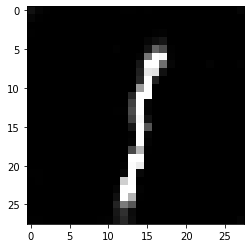

Batch 410 of 1875 Discriminator Loss: 0.4304 Generator Loss: 2.2550
Batch 420 of 1875 Discriminator Loss: 0.7642 Generator Loss: 2.2538
Batch 430 of 1875 Discriminator Loss: 0.6506 Generator Loss: 1.2558
Batch 440 of 1875 Discriminator Loss: 0.7744 Generator Loss: 1.3354
Batch 450 of 1875 Discriminator Loss: 0.4876 Generator Loss: 1.8876
Batch 460 of 1875 Discriminator Loss: 0.8907 Generator Loss: 1.2053
Batch 470 of 1875 Discriminator Loss: 0.4594 Generator Loss: 1.6932
Batch 480 of 1875 Discriminator Loss: 0.7461 Generator Loss: 1.1127
Batch 490 of 1875 Discriminator Loss: 0.5503 Generator Loss: 1.6049
Batch 500 of 1875 Discriminator Loss: 0.6338 Generator Loss: 2.2390


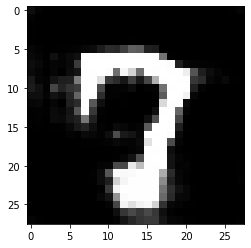

Batch 510 of 1875 Discriminator Loss: 0.4671 Generator Loss: 1.8882
Batch 520 of 1875 Discriminator Loss: 0.6975 Generator Loss: 1.5060
Batch 530 of 1875 Discriminator Loss: 0.4568 Generator Loss: 2.1832
Batch 540 of 1875 Discriminator Loss: 0.4819 Generator Loss: 2.0686
Batch 550 of 1875 Discriminator Loss: 1.3152 Generator Loss: 3.0363
Batch 560 of 1875 Discriminator Loss: 0.5303 Generator Loss: 1.8904
Batch 570 of 1875 Discriminator Loss: 0.7694 Generator Loss: 1.0392
Batch 580 of 1875 Discriminator Loss: 0.8489 Generator Loss: 2.3672
Batch 590 of 1875 Discriminator Loss: 0.9664 Generator Loss: 0.7006
Batch 600 of 1875 Discriminator Loss: 0.4595 Generator Loss: 1.7611


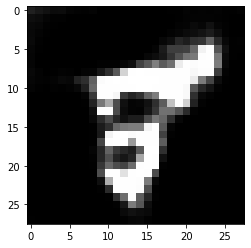

Batch 610 of 1875 Discriminator Loss: 0.5241 Generator Loss: 1.5986
Batch 620 of 1875 Discriminator Loss: 0.7057 Generator Loss: 1.2852
Batch 630 of 1875 Discriminator Loss: 0.5547 Generator Loss: 1.8870
Batch 640 of 1875 Discriminator Loss: 0.5670 Generator Loss: 2.4520
Batch 650 of 1875 Discriminator Loss: 0.4269 Generator Loss: 1.6768
Batch 660 of 1875 Discriminator Loss: 0.6489 Generator Loss: 2.8496
Batch 670 of 1875 Discriminator Loss: 0.5390 Generator Loss: 1.9658
Batch 680 of 1875 Discriminator Loss: 0.9696 Generator Loss: 0.7396
Batch 690 of 1875 Discriminator Loss: 0.5103 Generator Loss: 1.8570
Batch 700 of 1875 Discriminator Loss: 0.6023 Generator Loss: 1.2495


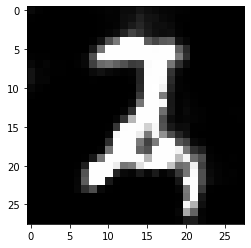

Batch 710 of 1875 Discriminator Loss: 1.1111 Generator Loss: 0.7669
Batch 720 of 1875 Discriminator Loss: 0.5823 Generator Loss: 1.8501
Batch 730 of 1875 Discriminator Loss: 0.8878 Generator Loss: 3.4757
Batch 740 of 1875 Discriminator Loss: 0.5505 Generator Loss: 2.3938
Batch 750 of 1875 Discriminator Loss: 0.7720 Generator Loss: 1.4435
Batch 760 of 1875 Discriminator Loss: 0.9033 Generator Loss: 1.1264
Batch 770 of 1875 Discriminator Loss: 0.5124 Generator Loss: 1.9513
Batch 780 of 1875 Discriminator Loss: 0.8718 Generator Loss: 2.5070
Batch 790 of 1875 Discriminator Loss: 0.6495 Generator Loss: 1.2200
Batch 800 of 1875 Discriminator Loss: 0.5091 Generator Loss: 3.4566


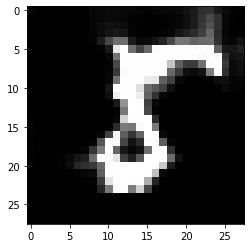

Batch 810 of 1875 Discriminator Loss: 0.5406 Generator Loss: 1.3950
Batch 820 of 1875 Discriminator Loss: 0.5547 Generator Loss: 1.3489
Batch 830 of 1875 Discriminator Loss: 0.4277 Generator Loss: 2.0606
Batch 840 of 1875 Discriminator Loss: 0.6149 Generator Loss: 1.6364
Batch 850 of 1875 Discriminator Loss: 0.5552 Generator Loss: 1.5798
Batch 860 of 1875 Discriminator Loss: 0.6187 Generator Loss: 3.4657
Batch 870 of 1875 Discriminator Loss: 0.5314 Generator Loss: 1.5396
Batch 880 of 1875 Discriminator Loss: 1.2872 Generator Loss: 0.7611
Batch 890 of 1875 Discriminator Loss: 0.4990 Generator Loss: 1.8813
Batch 900 of 1875 Discriminator Loss: 0.7398 Generator Loss: 1.5467


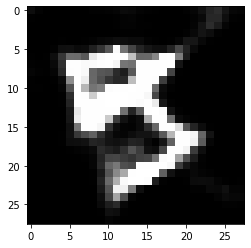

Batch 910 of 1875 Discriminator Loss: 0.5489 Generator Loss: 1.5464
Batch 920 of 1875 Discriminator Loss: 0.4739 Generator Loss: 1.7898
Batch 930 of 1875 Discriminator Loss: 0.5122 Generator Loss: 2.1682
Batch 940 of 1875 Discriminator Loss: 0.5900 Generator Loss: 2.9115
Batch 950 of 1875 Discriminator Loss: 0.4165 Generator Loss: 2.4627
Batch 960 of 1875 Discriminator Loss: 0.4373 Generator Loss: 2.4070
Batch 970 of 1875 Discriminator Loss: 0.5350 Generator Loss: 2.1454
Batch 980 of 1875 Discriminator Loss: 0.5932 Generator Loss: 1.8882
Batch 990 of 1875 Discriminator Loss: 0.5169 Generator Loss: 2.8340
Batch 1000 of 1875 Discriminator Loss: 0.5366 Generator Loss: 2.1680


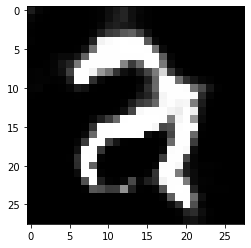

Batch 1010 of 1875 Discriminator Loss: 0.8041 Generator Loss: 0.9495
Batch 1020 of 1875 Discriminator Loss: 0.4575 Generator Loss: 2.3105
Batch 1030 of 1875 Discriminator Loss: 0.8063 Generator Loss: 0.9650
Batch 1040 of 1875 Discriminator Loss: 0.4674 Generator Loss: 1.7280
Batch 1050 of 1875 Discriminator Loss: 0.4926 Generator Loss: 2.0186
Batch 1060 of 1875 Discriminator Loss: 0.4121 Generator Loss: 2.8551
Batch 1070 of 1875 Discriminator Loss: 0.3534 Generator Loss: 2.0920
Batch 1080 of 1875 Discriminator Loss: 0.6046 Generator Loss: 1.4605
Batch 1090 of 1875 Discriminator Loss: 0.4546 Generator Loss: 1.5513
Batch 1100 of 1875 Discriminator Loss: 0.3685 Generator Loss: 2.7748


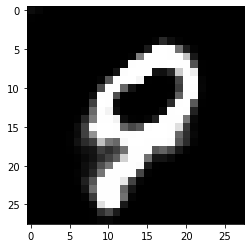

Batch 1110 of 1875 Discriminator Loss: 0.4084 Generator Loss: 2.1690
Batch 1120 of 1875 Discriminator Loss: 0.4342 Generator Loss: 2.0093
Batch 1130 of 1875 Discriminator Loss: 0.5719 Generator Loss: 1.4045
Batch 1140 of 1875 Discriminator Loss: 0.4330 Generator Loss: 2.1968
Batch 1150 of 1875 Discriminator Loss: 0.3214 Generator Loss: 1.9977
Batch 1160 of 1875 Discriminator Loss: 0.3267 Generator Loss: 1.8975
Batch 1170 of 1875 Discriminator Loss: 0.4867 Generator Loss: 1.6826
Batch 1180 of 1875 Discriminator Loss: 0.4371 Generator Loss: 3.4128
Batch 1190 of 1875 Discriminator Loss: 0.4936 Generator Loss: 1.5520
Batch 1200 of 1875 Discriminator Loss: 0.4412 Generator Loss: 3.1661


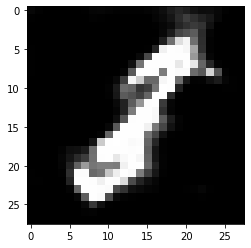

Batch 1210 of 1875 Discriminator Loss: 0.5796 Generator Loss: 1.5026
Batch 1220 of 1875 Discriminator Loss: 1.0430 Generator Loss: 0.8245
Batch 1230 of 1875 Discriminator Loss: 0.4276 Generator Loss: 2.5938
Batch 1240 of 1875 Discriminator Loss: 0.4152 Generator Loss: 1.9681
Batch 1250 of 1875 Discriminator Loss: 0.2883 Generator Loss: 2.9809
Batch 1260 of 1875 Discriminator Loss: 0.4055 Generator Loss: 2.3918
Batch 1270 of 1875 Discriminator Loss: 0.7774 Generator Loss: 0.9378
Batch 1280 of 1875 Discriminator Loss: 0.4457 Generator Loss: 2.9827
Batch 1290 of 1875 Discriminator Loss: 0.5820 Generator Loss: 2.6712
Batch 1300 of 1875 Discriminator Loss: 0.3979 Generator Loss: 2.3213


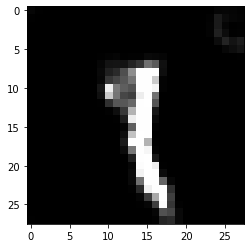

Batch 1310 of 1875 Discriminator Loss: 0.3238 Generator Loss: 2.3688
Batch 1320 of 1875 Discriminator Loss: 0.4602 Generator Loss: 1.8507
Batch 1330 of 1875 Discriminator Loss: 0.4586 Generator Loss: 2.9134
Batch 1340 of 1875 Discriminator Loss: 0.4773 Generator Loss: 1.5136
Batch 1350 of 1875 Discriminator Loss: 0.2577 Generator Loss: 3.5229
Batch 1360 of 1875 Discriminator Loss: 0.2513 Generator Loss: 3.1119
Batch 1370 of 1875 Discriminator Loss: 0.3376 Generator Loss: 3.3212
Batch 1380 of 1875 Discriminator Loss: 0.2397 Generator Loss: 2.8259
Batch 1390 of 1875 Discriminator Loss: 0.2598 Generator Loss: 2.6561
Batch 1400 of 1875 Discriminator Loss: 0.2881 Generator Loss: 3.4965


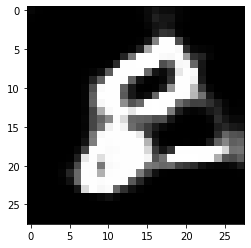

Batch 1410 of 1875 Discriminator Loss: 0.4077 Generator Loss: 1.7237
Batch 1420 of 1875 Discriminator Loss: 0.3190 Generator Loss: 2.9475
Batch 1430 of 1875 Discriminator Loss: 0.4609 Generator Loss: 1.6190
Batch 1440 of 1875 Discriminator Loss: 0.3640 Generator Loss: 2.2588
Batch 1450 of 1875 Discriminator Loss: 0.2883 Generator Loss: 2.4354
Batch 1460 of 1875 Discriminator Loss: 0.5364 Generator Loss: 2.1438
Batch 1470 of 1875 Discriminator Loss: 0.2654 Generator Loss: 3.1183
Batch 1480 of 1875 Discriminator Loss: 0.5900 Generator Loss: 1.5303
Batch 1490 of 1875 Discriminator Loss: 0.4073 Generator Loss: 1.7911
Batch 1500 of 1875 Discriminator Loss: 0.2084 Generator Loss: 3.7283


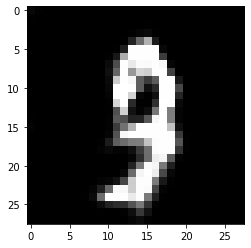

Batch 1510 of 1875 Discriminator Loss: 0.2966 Generator Loss: 2.5900
Batch 1520 of 1875 Discriminator Loss: 0.2523 Generator Loss: 2.5603
Batch 1530 of 1875 Discriminator Loss: 0.5049 Generator Loss: 2.1790
Batch 1540 of 1875 Discriminator Loss: 0.3058 Generator Loss: 3.0410
Batch 1550 of 1875 Discriminator Loss: 0.4683 Generator Loss: 1.8709
Batch 1560 of 1875 Discriminator Loss: 0.9626 Generator Loss: 1.1784
Batch 1570 of 1875 Discriminator Loss: 0.3408 Generator Loss: 2.0319
Batch 1580 of 1875 Discriminator Loss: 0.4524 Generator Loss: 1.7044
Batch 1590 of 1875 Discriminator Loss: 0.4153 Generator Loss: 1.7641
Batch 1600 of 1875 Discriminator Loss: 0.3457 Generator Loss: 2.6383


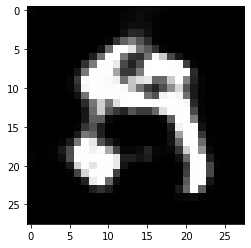

Batch 1610 of 1875 Discriminator Loss: 0.2664 Generator Loss: 2.2727
Batch 1620 of 1875 Discriminator Loss: 0.3442 Generator Loss: 3.7641
Batch 1630 of 1875 Discriminator Loss: 0.4237 Generator Loss: 1.8223
Batch 1640 of 1875 Discriminator Loss: 0.2833 Generator Loss: 2.5085
Batch 1650 of 1875 Discriminator Loss: 0.2862 Generator Loss: 4.2586
Batch 1660 of 1875 Discriminator Loss: 0.2997 Generator Loss: 2.7359
Batch 1670 of 1875 Discriminator Loss: 0.1947 Generator Loss: 2.7948
Batch 1680 of 1875 Discriminator Loss: 0.4009 Generator Loss: 3.0360
Batch 1690 of 1875 Discriminator Loss: 0.3521 Generator Loss: 2.2877
Batch 1700 of 1875 Discriminator Loss: 0.2189 Generator Loss: 4.0096


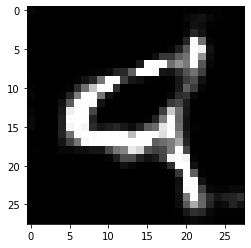

Batch 1710 of 1875 Discriminator Loss: 0.4189 Generator Loss: 1.9052
Batch 1720 of 1875 Discriminator Loss: 0.3237 Generator Loss: 2.5524
Batch 1730 of 1875 Discriminator Loss: 0.3220 Generator Loss: 3.1227
Batch 1740 of 1875 Discriminator Loss: 0.4857 Generator Loss: 1.4880
Batch 1750 of 1875 Discriminator Loss: 0.3836 Generator Loss: 2.1893
Batch 1760 of 1875 Discriminator Loss: 0.4729 Generator Loss: 3.9211
Batch 1770 of 1875 Discriminator Loss: 0.2199 Generator Loss: 2.7692
Batch 1780 of 1875 Discriminator Loss: 0.1727 Generator Loss: 3.2009
Batch 1790 of 1875 Discriminator Loss: 0.4107 Generator Loss: 2.0715
Batch 1800 of 1875 Discriminator Loss: 0.2867 Generator Loss: 2.8392


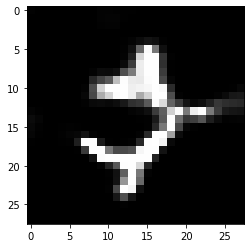

Batch 1810 of 1875 Discriminator Loss: 0.2765 Generator Loss: 2.7641
Batch 1820 of 1875 Discriminator Loss: 0.4388 Generator Loss: 2.0472
Batch 1830 of 1875 Discriminator Loss: 0.4122 Generator Loss: 1.8471
Batch 1840 of 1875 Discriminator Loss: 0.3072 Generator Loss: 2.0970
Batch 1850 of 1875 Discriminator Loss: 0.3654 Generator Loss: 2.0260
Batch 1860 of 1875 Discriminator Loss: 0.3050 Generator Loss: 2.6731
Batch 1870 of 1875 Discriminator Loss: 0.3964 Generator Loss: 2.4477
Starting epoch 2 of 2
Batch 0 of 1875 Discriminator Loss: 0.2468 Generator Loss: 3.1016


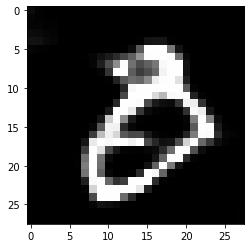

Batch 10 of 1875 Discriminator Loss: 0.2990 Generator Loss: 3.3612
Batch 20 of 1875 Discriminator Loss: 0.2310 Generator Loss: 2.7556
Batch 30 of 1875 Discriminator Loss: 0.2172 Generator Loss: 2.8351
Batch 40 of 1875 Discriminator Loss: 0.2733 Generator Loss: 4.1269
Batch 50 of 1875 Discriminator Loss: 0.3739 Generator Loss: 2.9886
Batch 60 of 1875 Discriminator Loss: 0.3139 Generator Loss: 2.4135
Batch 70 of 1875 Discriminator Loss: 0.3518 Generator Loss: 2.4179
Batch 80 of 1875 Discriminator Loss: 0.6311 Generator Loss: 1.9946
Batch 90 of 1875 Discriminator Loss: 0.3059 Generator Loss: 2.5198
Batch 100 of 1875 Discriminator Loss: 0.3404 Generator Loss: 2.0439


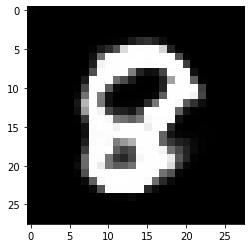

Batch 110 of 1875 Discriminator Loss: 0.3690 Generator Loss: 2.9503
Batch 120 of 1875 Discriminator Loss: 0.1982 Generator Loss: 3.6592
Batch 130 of 1875 Discriminator Loss: 0.2296 Generator Loss: 2.8927
Batch 140 of 1875 Discriminator Loss: 0.2307 Generator Loss: 2.7101
Batch 150 of 1875 Discriminator Loss: 0.2741 Generator Loss: 4.1942
Batch 160 of 1875 Discriminator Loss: 0.5648 Generator Loss: 1.4131
Batch 170 of 1875 Discriminator Loss: 0.2615 Generator Loss: 2.2588
Batch 180 of 1875 Discriminator Loss: 0.5669 Generator Loss: 1.4752
Batch 190 of 1875 Discriminator Loss: 0.3252 Generator Loss: 2.3561
Batch 200 of 1875 Discriminator Loss: 0.1521 Generator Loss: 3.4090


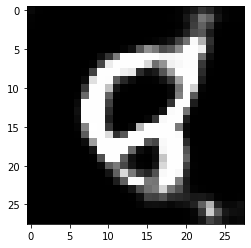

Batch 210 of 1875 Discriminator Loss: 0.2626 Generator Loss: 2.5992
Batch 220 of 1875 Discriminator Loss: 0.1442 Generator Loss: 3.5965
Batch 230 of 1875 Discriminator Loss: 0.1602 Generator Loss: 3.1904
Batch 240 of 1875 Discriminator Loss: 0.3428 Generator Loss: 1.8061
Batch 250 of 1875 Discriminator Loss: 0.2868 Generator Loss: 5.1059
Batch 260 of 1875 Discriminator Loss: 0.2971 Generator Loss: 2.7106
Batch 270 of 1875 Discriminator Loss: 0.2364 Generator Loss: 3.1445
Batch 280 of 1875 Discriminator Loss: 0.1642 Generator Loss: 3.7740
Batch 290 of 1875 Discriminator Loss: 0.3023 Generator Loss: 2.5500
Batch 300 of 1875 Discriminator Loss: 0.2717 Generator Loss: 2.3810


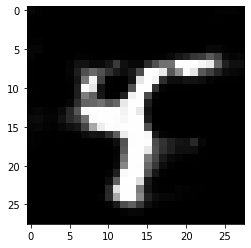

Batch 310 of 1875 Discriminator Loss: 0.3742 Generator Loss: 3.1862
Batch 320 of 1875 Discriminator Loss: 0.2340 Generator Loss: 3.1931
Batch 330 of 1875 Discriminator Loss: 0.2247 Generator Loss: 3.2371
Batch 340 of 1875 Discriminator Loss: 0.1284 Generator Loss: 3.8330
Batch 350 of 1875 Discriminator Loss: 0.1545 Generator Loss: 3.3041
Batch 360 of 1875 Discriminator Loss: 0.1704 Generator Loss: 4.3193
Batch 370 of 1875 Discriminator Loss: 0.3037 Generator Loss: 2.4388
Batch 380 of 1875 Discriminator Loss: 0.1662 Generator Loss: 4.8746
Batch 390 of 1875 Discriminator Loss: 0.3618 Generator Loss: 2.3134
Batch 400 of 1875 Discriminator Loss: 0.2410 Generator Loss: 2.4458


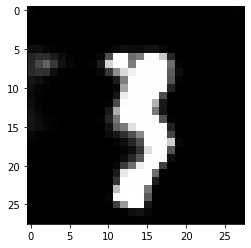

Batch 410 of 1875 Discriminator Loss: 0.1777 Generator Loss: 3.4936
Batch 420 of 1875 Discriminator Loss: 0.1977 Generator Loss: 2.7585
Batch 430 of 1875 Discriminator Loss: 0.2187 Generator Loss: 3.7172
Batch 440 of 1875 Discriminator Loss: 0.1520 Generator Loss: 3.7780
Batch 450 of 1875 Discriminator Loss: 0.1876 Generator Loss: 3.7423
Batch 460 of 1875 Discriminator Loss: 0.1778 Generator Loss: 3.5224
Batch 470 of 1875 Discriminator Loss: 0.0997 Generator Loss: 4.4991
Batch 480 of 1875 Discriminator Loss: 0.2532 Generator Loss: 2.8864
Batch 490 of 1875 Discriminator Loss: 0.6232 Generator Loss: 1.7555
Batch 500 of 1875 Discriminator Loss: 0.2945 Generator Loss: 4.2959


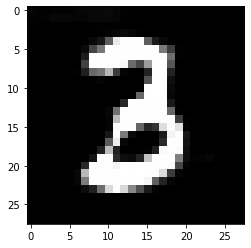

Batch 510 of 1875 Discriminator Loss: 0.2414 Generator Loss: 2.6934
Batch 520 of 1875 Discriminator Loss: 0.1170 Generator Loss: 3.1104
Batch 530 of 1875 Discriminator Loss: 0.1276 Generator Loss: 3.5598
Batch 540 of 1875 Discriminator Loss: 0.1954 Generator Loss: 2.9764
Batch 550 of 1875 Discriminator Loss: 0.3470 Generator Loss: 2.1603
Batch 560 of 1875 Discriminator Loss: 0.1623 Generator Loss: 3.8424
Batch 570 of 1875 Discriminator Loss: 0.1344 Generator Loss: 3.1769
Batch 580 of 1875 Discriminator Loss: 0.2291 Generator Loss: 3.4631
Batch 590 of 1875 Discriminator Loss: 0.4635 Generator Loss: 1.9389
Batch 600 of 1875 Discriminator Loss: 0.1440 Generator Loss: 3.4878


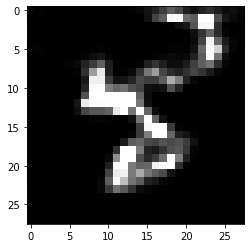

Batch 610 of 1875 Discriminator Loss: 0.1818 Generator Loss: 3.4028
Batch 620 of 1875 Discriminator Loss: 0.3414 Generator Loss: 2.0103
Batch 630 of 1875 Discriminator Loss: 0.1074 Generator Loss: 3.7350
Batch 640 of 1875 Discriminator Loss: 0.1378 Generator Loss: 3.1670
Batch 650 of 1875 Discriminator Loss: 0.0839 Generator Loss: 6.0761
Batch 660 of 1875 Discriminator Loss: 0.2570 Generator Loss: 3.2453
Batch 670 of 1875 Discriminator Loss: 0.3187 Generator Loss: 2.6769
Batch 680 of 1875 Discriminator Loss: 0.4348 Generator Loss: 1.8059
Batch 690 of 1875 Discriminator Loss: 0.1256 Generator Loss: 3.9080
Batch 700 of 1875 Discriminator Loss: 0.2063 Generator Loss: 3.5175


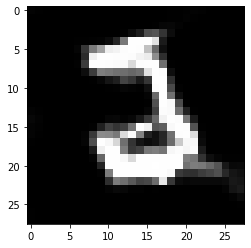

Batch 710 of 1875 Discriminator Loss: 0.1993 Generator Loss: 2.9162
Batch 720 of 1875 Discriminator Loss: 0.1333 Generator Loss: 3.5938
Batch 730 of 1875 Discriminator Loss: 0.2169 Generator Loss: 3.1215
Batch 740 of 1875 Discriminator Loss: 0.2089 Generator Loss: 3.2239
Batch 750 of 1875 Discriminator Loss: 0.0758 Generator Loss: 4.0108
Batch 760 of 1875 Discriminator Loss: 0.1088 Generator Loss: 4.5969
Batch 770 of 1875 Discriminator Loss: 0.1490 Generator Loss: 3.3510
Batch 780 of 1875 Discriminator Loss: 0.1778 Generator Loss: 3.1887
Batch 790 of 1875 Discriminator Loss: 0.1894 Generator Loss: 3.1383
Batch 800 of 1875 Discriminator Loss: 0.0799 Generator Loss: 4.7175


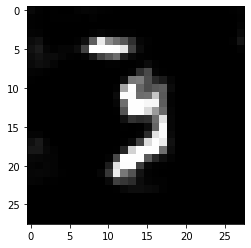

Batch 810 of 1875 Discriminator Loss: 0.2456 Generator Loss: 4.1484
Batch 820 of 1875 Discriminator Loss: 0.1190 Generator Loss: 3.6606
Batch 830 of 1875 Discriminator Loss: 0.1469 Generator Loss: 4.2189
Batch 840 of 1875 Discriminator Loss: 0.2638 Generator Loss: 2.6250
Batch 850 of 1875 Discriminator Loss: 0.2299 Generator Loss: 2.8037
Batch 860 of 1875 Discriminator Loss: 0.1920 Generator Loss: 2.7216
Batch 870 of 1875 Discriminator Loss: 0.1026 Generator Loss: 3.7720
Batch 880 of 1875 Discriminator Loss: 0.4260 Generator Loss: 1.8934
Batch 890 of 1875 Discriminator Loss: 0.1403 Generator Loss: 3.6012
Batch 900 of 1875 Discriminator Loss: 0.2059 Generator Loss: 2.4689


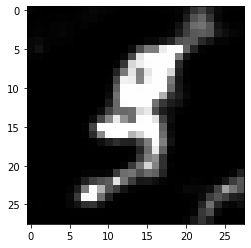

Batch 910 of 1875 Discriminator Loss: 0.0810 Generator Loss: 3.6672
Batch 920 of 1875 Discriminator Loss: 0.1769 Generator Loss: 3.6318
Batch 930 of 1875 Discriminator Loss: 0.0919 Generator Loss: 3.7257
Batch 940 of 1875 Discriminator Loss: 0.1679 Generator Loss: 3.0288
Batch 950 of 1875 Discriminator Loss: 0.0646 Generator Loss: 5.1211
Batch 960 of 1875 Discriminator Loss: 0.0473 Generator Loss: 4.9446
Batch 970 of 1875 Discriminator Loss: 0.1305 Generator Loss: 3.5076
Batch 980 of 1875 Discriminator Loss: 0.1373 Generator Loss: 4.8230
Batch 990 of 1875 Discriminator Loss: 0.1587 Generator Loss: 4.5151
Batch 1000 of 1875 Discriminator Loss: 0.1171 Generator Loss: 4.3297


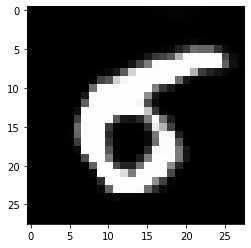

Batch 1010 of 1875 Discriminator Loss: 0.3012 Generator Loss: 2.9358
Batch 1020 of 1875 Discriminator Loss: 0.7187 Generator Loss: 1.5836
Batch 1030 of 1875 Discriminator Loss: 0.0388 Generator Loss: 4.5934
Batch 1040 of 1875 Discriminator Loss: 0.1547 Generator Loss: 3.8841
Batch 1050 of 1875 Discriminator Loss: 0.2969 Generator Loss: 2.1150
Batch 1060 of 1875 Discriminator Loss: 0.0774 Generator Loss: 4.2296
Batch 1070 of 1875 Discriminator Loss: 0.1230 Generator Loss: 3.5309
Batch 1080 of 1875 Discriminator Loss: 0.4673 Generator Loss: 2.3997
Batch 1090 of 1875 Discriminator Loss: 0.2321 Generator Loss: 2.6658
Batch 1100 of 1875 Discriminator Loss: 0.1908 Generator Loss: 3.3049


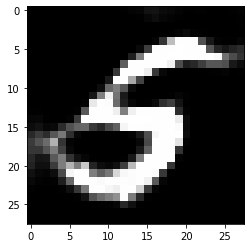

Batch 1110 of 1875 Discriminator Loss: 0.1162 Generator Loss: 4.8669
Batch 1120 of 1875 Discriminator Loss: 0.0847 Generator Loss: 4.8864
Batch 1130 of 1875 Discriminator Loss: 0.5163 Generator Loss: 1.7697
Batch 1140 of 1875 Discriminator Loss: 0.2811 Generator Loss: 2.4758
Batch 1150 of 1875 Discriminator Loss: 0.2975 Generator Loss: 2.3304
Batch 1160 of 1875 Discriminator Loss: 0.0819 Generator Loss: 4.1890
Batch 1170 of 1875 Discriminator Loss: 0.1177 Generator Loss: 4.6965
Batch 1180 of 1875 Discriminator Loss: 0.0969 Generator Loss: 4.4165
Batch 1190 of 1875 Discriminator Loss: 0.1368 Generator Loss: 5.3431
Batch 1200 of 1875 Discriminator Loss: 0.0952 Generator Loss: 3.7332


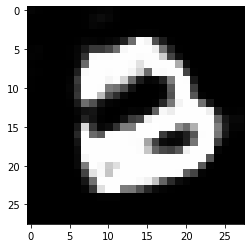

Batch 1210 of 1875 Discriminator Loss: 2.1283 Generator Loss: 1.3614
Batch 1220 of 1875 Discriminator Loss: 0.3727 Generator Loss: 1.8634
Batch 1230 of 1875 Discriminator Loss: 0.1635 Generator Loss: 3.3392
Batch 1240 of 1875 Discriminator Loss: 0.1679 Generator Loss: 2.4822
Batch 1250 of 1875 Discriminator Loss: 0.1142 Generator Loss: 2.9879
Batch 1260 of 1875 Discriminator Loss: 0.1305 Generator Loss: 2.9636
Batch 1270 of 1875 Discriminator Loss: 0.3476 Generator Loss: 2.1471
Batch 1280 of 1875 Discriminator Loss: 0.1749 Generator Loss: 2.8130
Batch 1290 of 1875 Discriminator Loss: 0.0973 Generator Loss: 4.2288
Batch 1300 of 1875 Discriminator Loss: 0.4861 Generator Loss: 2.1467


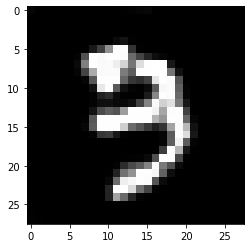

Batch 1310 of 1875 Discriminator Loss: 0.0985 Generator Loss: 4.3717
Batch 1320 of 1875 Discriminator Loss: 0.5529 Generator Loss: 1.6011
Batch 1330 of 1875 Discriminator Loss: 0.3993 Generator Loss: 1.8450
Batch 1340 of 1875 Discriminator Loss: 0.0866 Generator Loss: 4.1896
Batch 1350 of 1875 Discriminator Loss: 0.0702 Generator Loss: 3.9802
Batch 1360 of 1875 Discriminator Loss: 0.1384 Generator Loss: 2.8948
Batch 1370 of 1875 Discriminator Loss: 0.1595 Generator Loss: 3.7863
Batch 1380 of 1875 Discriminator Loss: 0.0829 Generator Loss: 3.6759
Batch 1390 of 1875 Discriminator Loss: 0.1200 Generator Loss: 4.5661
Batch 1400 of 1875 Discriminator Loss: 0.1465 Generator Loss: 3.7031


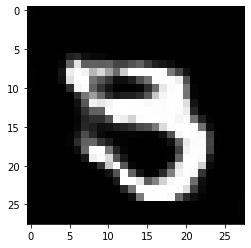

Batch 1410 of 1875 Discriminator Loss: 0.2092 Generator Loss: 5.4792
Batch 1420 of 1875 Discriminator Loss: 0.1494 Generator Loss: 4.4840
Batch 1430 of 1875 Discriminator Loss: 0.1568 Generator Loss: 4.4261
Batch 1440 of 1875 Discriminator Loss: 0.2190 Generator Loss: 2.9335
Batch 1450 of 1875 Discriminator Loss: 0.1916 Generator Loss: 2.8939
Batch 1460 of 1875 Discriminator Loss: 0.3726 Generator Loss: 1.8656
Batch 1470 of 1875 Discriminator Loss: 0.3792 Generator Loss: 1.8965
Batch 1480 of 1875 Discriminator Loss: 0.2310 Generator Loss: 2.9365
Batch 1490 of 1875 Discriminator Loss: 0.1800 Generator Loss: 5.0527
Batch 1500 of 1875 Discriminator Loss: 0.0967 Generator Loss: 5.3012


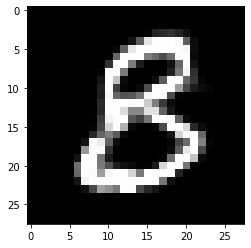

Batch 1510 of 1875 Discriminator Loss: 0.1543 Generator Loss: 3.2978
Batch 1520 of 1875 Discriminator Loss: 0.1835 Generator Loss: 3.0600
Batch 1530 of 1875 Discriminator Loss: 0.0781 Generator Loss: 4.1606
Batch 1540 of 1875 Discriminator Loss: 0.0981 Generator Loss: 5.1664
Batch 1550 of 1875 Discriminator Loss: 0.0980 Generator Loss: 4.0500
Batch 1560 of 1875 Discriminator Loss: 0.2297 Generator Loss: 2.9750
Batch 1570 of 1875 Discriminator Loss: 0.2022 Generator Loss: 3.6114
Batch 1580 of 1875 Discriminator Loss: 0.0226 Generator Loss: 6.6423
Batch 1590 of 1875 Discriminator Loss: 0.0618 Generator Loss: 4.3939
Batch 1600 of 1875 Discriminator Loss: 0.1089 Generator Loss: 3.6974


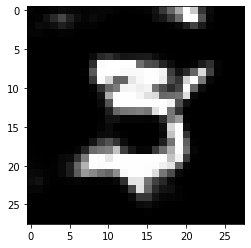

Batch 1610 of 1875 Discriminator Loss: 0.0726 Generator Loss: 5.7562
Batch 1620 of 1875 Discriminator Loss: 0.1670 Generator Loss: 3.6842
Batch 1630 of 1875 Discriminator Loss: 0.1412 Generator Loss: 3.2495
Batch 1640 of 1875 Discriminator Loss: 0.1031 Generator Loss: 4.1731
Batch 1650 of 1875 Discriminator Loss: 0.3050 Generator Loss: 3.9582
Batch 1660 of 1875 Discriminator Loss: 0.1274 Generator Loss: 3.4303
Batch 1670 of 1875 Discriminator Loss: 0.0510 Generator Loss: 4.3120
Batch 1680 of 1875 Discriminator Loss: 0.1133 Generator Loss: 4.3972
Batch 1690 of 1875 Discriminator Loss: 0.3081 Generator Loss: 2.0137
Batch 1700 of 1875 Discriminator Loss: 0.2041 Generator Loss: 3.0178


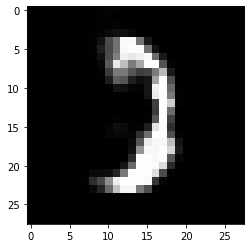

Batch 1710 of 1875 Discriminator Loss: 0.0634 Generator Loss: 4.5157
Batch 1720 of 1875 Discriminator Loss: 0.1695 Generator Loss: 3.0643
Batch 1730 of 1875 Discriminator Loss: 0.1131 Generator Loss: 5.3765
Batch 1740 of 1875 Discriminator Loss: 0.1171 Generator Loss: 4.2575
Batch 1750 of 1875 Discriminator Loss: 0.1361 Generator Loss: 5.1103
Batch 1760 of 1875 Discriminator Loss: 0.0427 Generator Loss: 4.4389
Batch 1770 of 1875 Discriminator Loss: 0.1189 Generator Loss: 5.3635
Batch 1780 of 1875 Discriminator Loss: 0.1430 Generator Loss: 3.6877
Batch 1790 of 1875 Discriminator Loss: 0.1194 Generator Loss: 4.3414
Batch 1800 of 1875 Discriminator Loss: 0.2143 Generator Loss: 3.5291


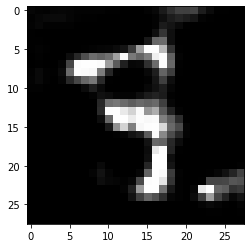

Batch 1810 of 1875 Discriminator Loss: 0.1767 Generator Loss: 2.8350
Batch 1820 of 1875 Discriminator Loss: 0.1883 Generator Loss: 2.7121


In [ ]:
epochs = 2
batch_size = 32
z_dim = 150
learning_rate = .001
beta1 = .5

mnist_dataset = glob('./mnist/*.jpg')
with tf.Graph().as_default():
    mnist_generator = MNIST_Generator(mnist_dataset, z_dim, beta1, epochs, batch_size, learning_rate)
    print(mnist_generator.data_shape)
    
    mnist_generator.train()